# Get the HPS model to run
- get the inputs correct
- run through all steps
- get an accuracy estimate

In [1]:
%matplotlib inline

In [2]:
import os
import sys
sys.path.append('/home/surchs/git/HPS')
from hps.predic import high_confidence
from hps.visu import hps_visu
#from proteus.predic import prediction

import numpy as np
import pandas as pd
import nibabel as nib
import sklearn as skl
import scipy.io as sio
import seaborn as sbn
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold

In [3]:
os.cpu_count()

32

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Paths
root_p = '/home/surchs/sim_big/PROJECT/abide_hps/'
# Pheno
sample_p = os.path.join(root_p, 'pheno', 'psm_abide1.csv')
# Data
resid_ct_p = os.path.join(root_p, 'residual', 'ct_30mm_residual_psm.npy')
resid_fc_p = os.path.join(root_p, 'residual', 'sd_30mm_residual_psm.npy')
mask_p = os.path.join(root_p, 'mask', 'MIST_mask.nii.gz')
subtype_fc_p = os.path.join(root_p, 'subtypes', 'subtypes_fc.npz')
subtype_ct_p = os.path.join(root_p, 'subtypes', 'subtypes_ct.npz')

In [6]:
# Load data
sample = pd.read_csv(sample_p)
sample['DX_CODE'] = sample['DX_GROUP'].replace({'Autism':1, 'Control':0})
s_fc = np.load(subtype_fc_p)
s_ct = np.load(subtype_ct_p)

In [7]:
# Reshape FC to add to the table
fc_weights = np.reshape(s_fc['weights'], (370, 5*20))
fc_cols = ['fc_n{}_s{}'.format(nid+1, sid+1) for sid in range(5) for nid in range(20)]
# Same for CT
ct_weights = s_ct['weights']
ct_cols = ['ct_s{}'.format(sid+1) for sid in range(5)]
# Combine both
weights = np.concatenate((ct_weights, fc_weights),1)
cols = ct_cols + fc_cols
# Into a pandas DF
w_data = pd.DataFrame(data=weights, columns=cols)
# Combine both for the full dataset
dataset = sample.join(w_data)

In [8]:
# Select the features
scaler = skl.preprocessing.StandardScaler()
# Add BV to the subtype weights
col_features = ['BV', 'AGE_AT_SCAN', 'FD_scrubbed', ] + cols

# Build features
x_ = dataset.loc[:, col_features]
# Take the numeric diagnosis code
y = dataset.loc[:, ['DX_CODE']].values.squeeze()
# Normalize
X = scaler.fit_transform(x_)

# Run the CV model

In [9]:
ohe = skl.preprocessing.OneHotEncoder(sparse=False)
ohe.fit(y.reshape(-1, 1))
labels = ohe.transform(y.reshape(-1, 1))

Stage 1
Stage 2
CV fold 1 classifying...
Stage 1
Stage 2
CV fold 2 classifying...
Stage 1
Stage 2
CV fold 3 classifying...
Stage 1
Stage 2
CV fold 4 classifying...
Stage 1
Stage 2
CV fold 5 classifying...
Stage 1
Stage 2
CV fold 6 classifying...
Stage 1
Stage 2
CV fold 7 classifying...
Stage 1
Stage 2
CV fold 8 classifying...
Stage 1
Stage 2
CV fold 9 classifying...
Stage 1
Stage 2
CV fold 10 classifying...


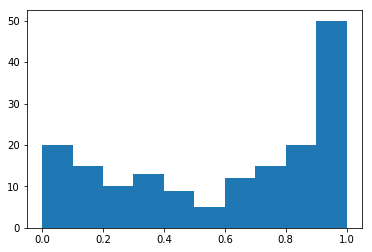

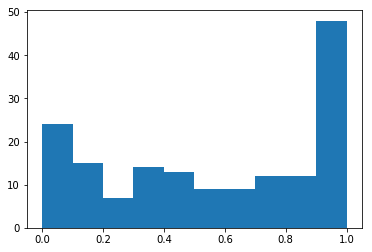

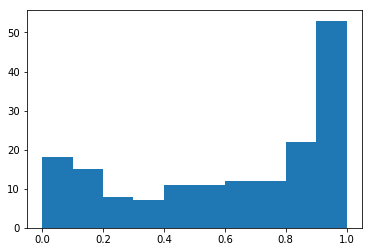

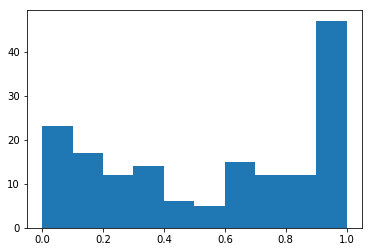

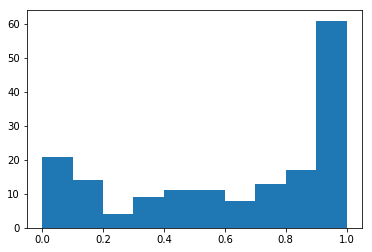

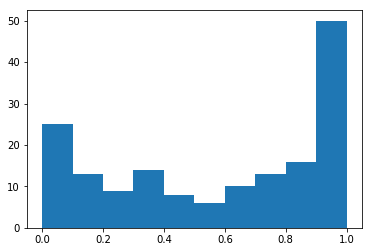

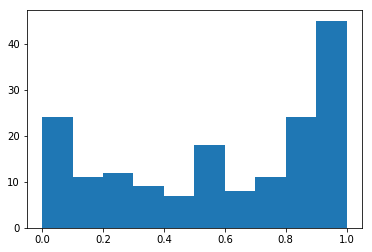

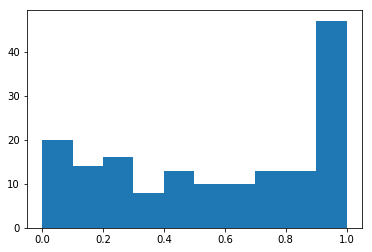

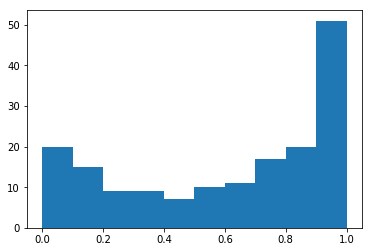

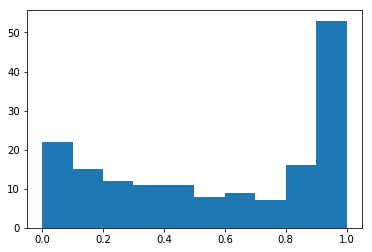

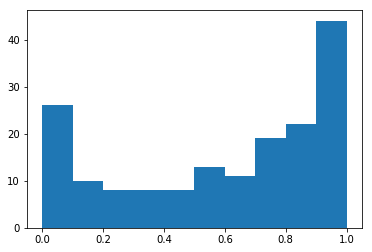

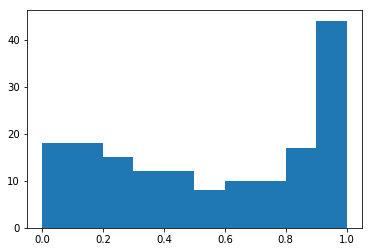

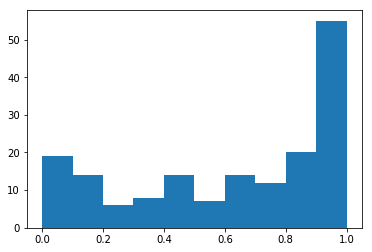

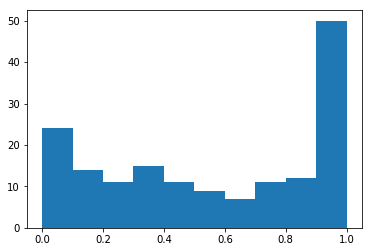

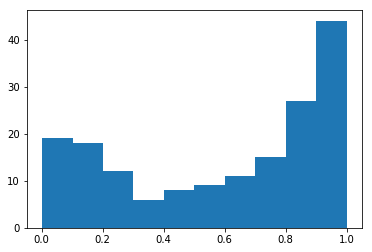

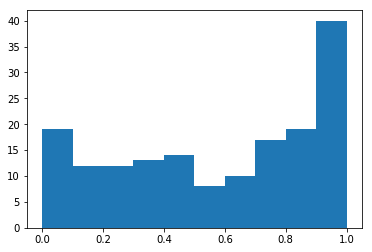

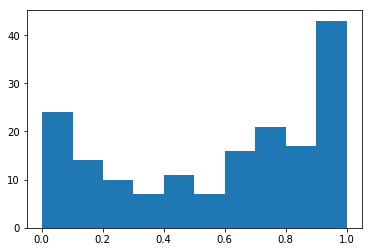

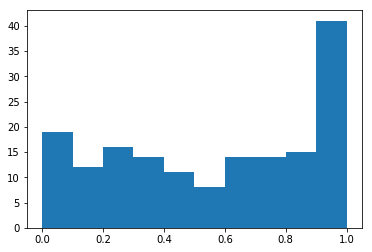

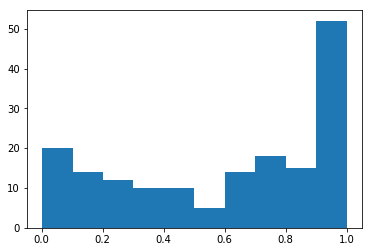

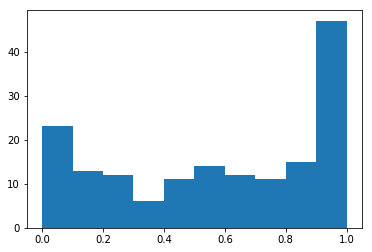

In [10]:
scores_s1=[]
scores_s2 = []
y_target = []

skf = StratifiedKFold(n_splits=10)
it = 1
for train_index, val_index in skf.split(X,y):
    X_training, X_val = X[train_index], X[val_index]
    y_training, y_val = y[train_index], y[val_index]
        
    hps = high_confidence.TwoStagesPrediction(verbose=False,
                                          n_iter=1000,
                                          shuffle_test_split=0.5,
                                            gamma=1,
                                          min_gamma=0.95,
                                          thresh_ratio=0.1)
    
    hps.fit(X_training, y_training)
    
    scores, dic_results = hps.predict(X_val)
    
    # Test in validation sample
    acc = skl.metrics.accuracy_score(y_val, (dic_results['s1_df'][:,0]>0).astype(float))
    tmp_mask = (dic_results['s2_hat'][:,1]>0) & (dic_results['s1_df'][:,0]>0)
    acc_s2 = skl.metrics.accuracy_score(y_val, (dic_results['s2_df'][:,1]>0).astype(float))
    
    scores_s1.append(dic_results['s1_hat'])
    scores_s2.append(dic_results['s2_hat'])
    
    print('CV fold {} classifying...'.format(it))
    it += 1
    
    plt.figure()
    plt.hist(hps.training_hit_probability[y_training==0],10)
    plt.figure()
    plt.hist(hps.training_hit_probability[y_training==1],10)
    
    y_target.append(y_val)

In [11]:
scores_s1 = np.vstack(scores_s1)
scores_s2 = np.vstack(scores_s2)
y_target = np.hstack(y_target)

########################
print('##########################')
# S1
y_mb = ohe.transform(y_target[:,np.newaxis])
pred_y_ = scores_s1

print('Stage 1 (BASE)')
hps_visu.print_scores(hps_visu.scores(y_mb, pred_y_))


# S2
y_mb = ohe.transform(y_target[:,np.newaxis])
pred_y_ = scores_s2

print('Stage 2 (HPS)')
hps_visu.print_scores(hps_visu.scores(y_mb, pred_y_)) 
print('##########################')

##########################
Stage 1 (BASE)
Class 0 Precision: 58.64 Specificity: 56.59 Recall: 59.57 N: 191
Class 1 Precision: 57.54 Specificity: 59.57 Recall: 56.59 N: 179
Total Precision: 58.09 Specificity: 58.08 Recall: 58.08 N: 185
Stage 2 (HPS)
Class 0 Precision: 78.05 Specificity: 95.05 Recall: 17.02 N: 41
Class 1 Precision: 82.93 Specificity: 96.28 Recall: 18.68 N: 41
Total Precision: 80.49 Specificity: 95.67 Recall: 17.85 N: 41
##########################


That looks pretty good, let's run this on the entire training set and see if it generalizes to the validation set

# Run the one-pass model

Stage 1
Stage 2


(array([ 23.,  17.,  15.,  11.,  12.,  12.,   9.,  12.,  18.,  53.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

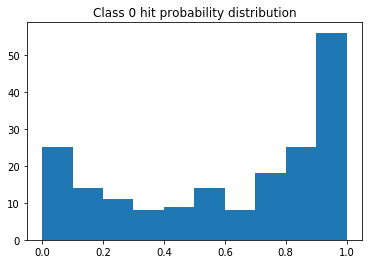

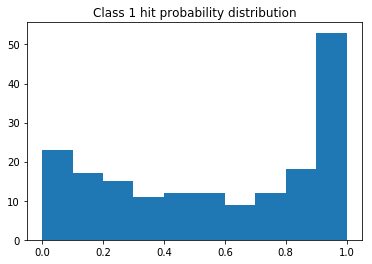

In [21]:
res_hitproba = []

hps = high_confidence.TwoStagesPrediction(verbose=False,
                                          n_iter=1000,
                                          shuffle_test_split=0.5,
                                          min_gamma=0.95,
                                          thresh_ratio=0.1)
hps.fit(X,y)
res_hitproba = hps.training_hit_probability

plt.figure()
plt.title('Class 0 hit probability distribution')
plt.hist(hps.training_hit_probability[y==0],10)
plt.figure()
plt.title('Class 1 hit probability distribution')
plt.hist(hps.training_hit_probability[y==1],10)

In [22]:
array_results, dict_results = hps.predict(X)

In [19]:
#ind_hps = (dict_results['s1_df'].flatten()>0).astype(float)
ind_hps = (dic_results['s2_df'][:,1]>0).astype(float)
ind_hps2 = dict_results['s2_df'].flatten()>0
lr_decision = dic_results['s2_df'][:,1]

In [20]:
lr_decision

array([-13.64991049, -22.9309682 , -12.43052258, -19.19481548,
       -14.50928935, -17.89568315, -10.47382893, -33.82002969,
       -31.86493711,  -6.696328  , -19.39497256, -11.3859038 ,
       -17.23383328,  -9.58479378,  -8.6284886 , -21.0083904 ,
       -13.61532876, -37.96888878,  -4.9150826 , -28.89765683,
        -7.82159816,   2.40134455, -24.21836014,   0.14253776,
       -20.40552568,  -1.20844632,   3.29176785, -19.64244466,
        -3.08011854, -22.72058524,  -3.98733363, -12.43204797,
       -19.69846905, -11.37219413, -18.82016804,   0.61362516])

In [17]:
y.shape

(370,)

In [18]:
np.sum(ind_hps)

4.0

In [16]:
print(skl.metrics.classification_report(y, ind_hps))

ValueError: Found input variables with inconsistent numbers of samples: [370, 36]

In [133]:
np.sum(ind_hps)

36.0

In [107]:
dict_results['s1_df']

array([[-0.999682  ],
       [-1.00010451],
       [-0.99958017],
       [-1.28754845],
       [ 0.76546756],
       [ 0.46094141],
       [-0.34641986],
       [-0.0581914 ],
       [-1.45933182],
       [ 1.0904185 ],
       [-0.10594713],
       [-0.58554593],
       [ 0.27967111],
       [ 0.68252858],
       [ 0.89817051],
       [ 0.14788048],
       [ 0.93210404],
       [ 1.27799012],
       [ 0.79131711],
       [-0.64880773],
       [ 0.74454123],
       [-0.90876294],
       [-0.60965746],
       [-0.86471239],
       [ 0.80257736],
       [-1.00042504],
       [-0.86907491],
       [-0.71984639],
       [ 0.07850339],
       [ 0.57402586],
       [-0.10843399],
       [ 0.42420916],
       [-1.56643376],
       [-0.99989916],
       [ 0.5019665 ],
       [ 0.67224713],
       [-0.1789051 ],
       [-0.45604225],
       [ 0.31722857],
       [-0.06726867],
       [ 0.38933004],
       [ 1.12659779],
       [-0.17588938],
       [ 1.03112507],
       [-0.08767509],
       [ 1

In [103]:
np.sum(ind_hps)

179

In [94]:
dict_results.keys()

dict_keys(['s1_hat', 'hcdf', 's2_df', 's1_df', 'hcjoint', 's2_hat', 'hitproba'])

## Get a hold of the feature weights in the model

In [67]:
feature_weights = hps.confidencemodel.clfs[1].coef_
non_zero = np.where(feature_weights!=0)[1]

In [81]:
col_nonzero = [col_features[ind] for ind in non_zero]
feature_type = list()
for col in col_nonzero:
    if 'ct' in col:
        feature_type.append('Anatomical')
    elif 'fc' in col:
        feature_type.append('Functional')
    else:
        feature_type.append('Phenotype')
data = {'weights':feature_weights[0, non_zero],
            'feature':col_nonzero,
            'feature_type':feature_type}
weights = pd.DataFrame(data=data)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]), <a list of 40 Text xticklabel objects>)

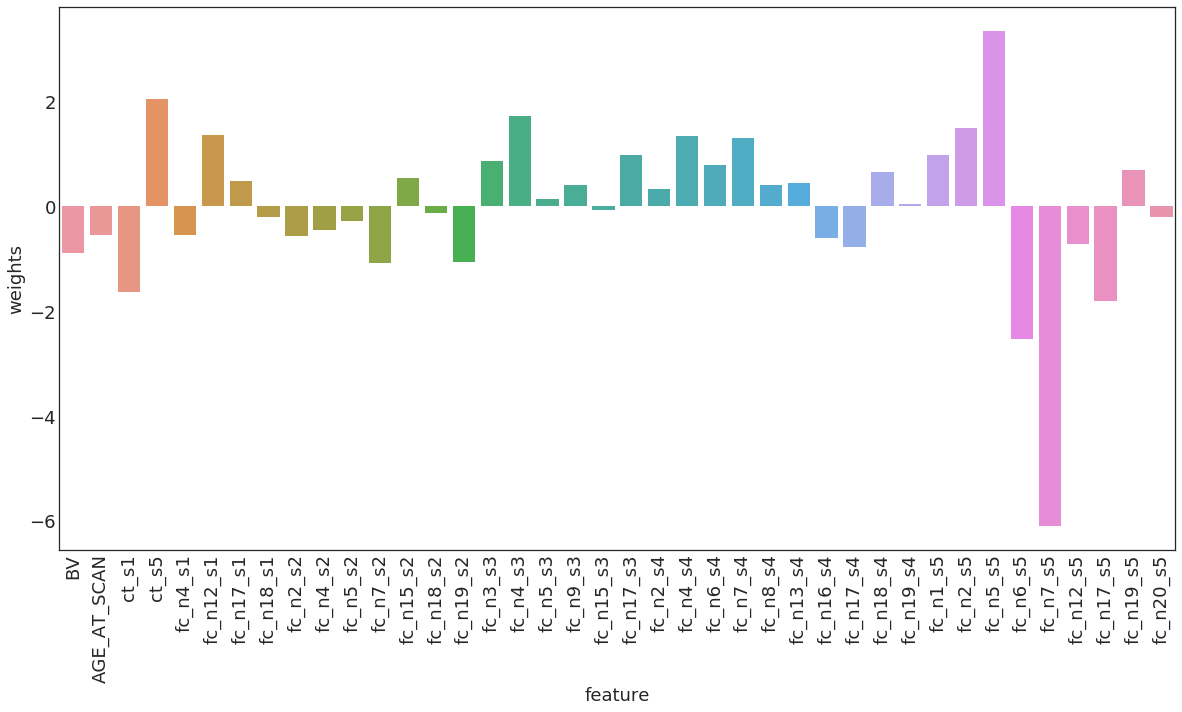

In [88]:
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(111)
#g = sbn.barplot(x='feature', y='weights', data=weights, hue='feature_type', ax=ax)
g = sbn.barplot(x='feature', y='weights', data=weights, ax=ax)
plt.xticks(rotation=90)

Check the composition of these groups

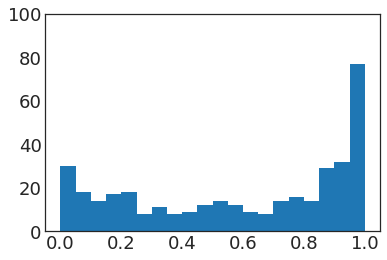

In [87]:
plt.hist(hps.training_hit_probability,20)
plt.ylim(0,100)
plt.rcParams.update({'font.size': 18})

NameError: name 'visu_demo' is not defined

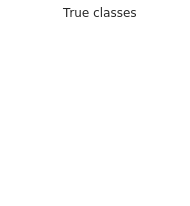

In [16]:
# Visualize the results
sbn.set_style("white")
fig = plt.figure(figsize=(3*4,3,))
ax1 = fig.add_subplot(1,4,1)
ax1.axis('off')
ax1.set_title("True classes")
visu_demo.scatter_points(X,y,new_fig=False,ax1=ax1)

ax1 = fig.add_subplot(1,4,2)
ax1.axis('off')
ax1.set_title("Basic")
visu_demo.plot_2classes(X,y,hps,show_class=[-1],ax1=ax1)

ax1 = fig.add_subplot(1,4,3)
ax1.axis('off')
ax1.set_title("Hit probabilities")
visu_demo.scatter_points(X,y,new_fig=False,res_hitproba=res_hitproba,ax1=ax1)

ax1 = fig.add_subplot(1,4,4)
ax1.axis('off')
ax1.set_title("Easy red cases")
visu_demo.plot_2classes(X,y,hps,show_class=[1],ax1=ax1)

In [7]:
# Prep store
store = {key:list() for key in ['accuracy_overall',
                                'accuracy_asd',
                                'precision_asd',
                                'precision_tdc',
                                'recall_asd',
                                'recall_tdc',
                                'f1_asd',
                                'f1_tdc'
                               ]}

# Run the model and see where that gets us
skf = StratifiedKFold(n_splits=3)
for train_index, val_index in skf.split(x_,y_):
    X_training, X_val = x_[train_index], x_[val_index]
    y_training, y_val = y_[train_index], y_[val_index]
    
    hpc = high_confidence.TwoStagesPrediction(
        n_iter=500,
        shuffle_test_split=0.5,
        min_gamma=.99,
        thresh_ratio=0.1)
    
    hpc.fit(X_training, X_training, y_training)
    _, dic_results = hpc.predict(X_val, X_val)
    acc = skl.metrics.accuracy_score(y_val, (dic_results['s1df'][:,0]>0).astype(float))
    store['accuracy_overall'].append(acc)
    
    # Get the guys we think are ASD
    pos_mask = (dic_results['s2df'][:,1]>0)
    acc_s2 = skl.metrics.accuracy_score(y_val[pos_mask], (dic_results['s1df'][:,0]>0).astype(float)[pos_mask])
    store['accuracy_asd'].append(acc_s2)
    
    print('Classifying TDC vs ASD...')
    print((dic_results['s1df'][:,0]>0).astype(float))
    
    y_pred = (dic_results['s1df'][:,0]>0).astype(float)
    # Compute precision of the classifier for ASD
    asd_p = skl.metrics.precision_score(y_val, y_pred, pos_label=1)
    store['precision_asd'].append(asd_p)
    # Compute precision of the classifier for TDC
    tdc_p = skl.metrics.precision_score(y_val, y_pred, pos_label=0)
    store['precision_tdc'].append(tdc_p)
    # Recall Ratio of ASD label
    asd_r = skl.metrics.recall_score(y_val, y_pred, pos_label=1)
    store['recall_asd'].append(asd_r)
    # Recall Ratio of TDC label
    tdc_r = skl.metrics.recall_score(y_val, y_pred, pos_label=0)
    store['recall_tdc'].append(tdc_r)
    # F1 Ratio of ASD label
    asd_f = skl.metrics.f1_score(y_val, y_pred, pos_label=1)
    store['f1_asd'].append(asd_f)
    # Recall Ratio of TDC label
    tdc_f = skl.metrics.f1_score(y_val, y_pred, pos_label=0)
    store['f1_tdc'].append(tdc_f)

Stage 1
Proba:
[ 0.2125      0.97560976  0.64566929  0.82945736  0.38076923  0.21982759
  0.          1.          0.888       0.82        0.97265625  0.95901639
  0.91891892  0.2987013   0.46692607  0.69411765  0.66938776  1.
  0.23505976  0.1719457   0.94274809  0.628       0.53125     0.76734694
  0.          0.05703422  0.98755187  0.53696498  0.072       0.98739496
  0.87966805  0.99630996  0.88284519  0.26492537  0.99193548  0.23236515
  0.94163424  0.352       0.74152542  0.72246696  0.36821705  0.09375
  0.06410256  0.62686567  0.76694915  0.72101449  0.91093117  0.68510638
  0.02991453  0.0122449   1.          0.75925926  0.01731602  0.82239382
  1.          0.781893    0.36781609  0.94693878  0.94605809  0.00796813
  0.88235294  0.05220884  0.57874016  0.05283019  0.8266129   0.98804781
  0.09615385  0.96995708  0.00757576  0.99598394  0.97975709  0.95
  0.99588477  0.3515625   0.28346457  0.00377358  0.45041322  0.04032258
  0.93869732  0.29718876  0.          0.71146245  0.9

Average hm score 0.0564516129032
Stage 2
Adjusted gamma:  0.99
Adjusted gamma:  0.99
Classifying TDC vs ASD...
[ 0.  1.  1.  0.  1.  1.  1.  1.  1.  1.  0.  1.  0.  0.  1.  1.  0.  1.
  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  1.  1.  1.  0.  1.  1.  1.
  1.  1.  0.  1.  0.  1.  1.  1.  1.  0.  0.  0.  1.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  1.  0.  0.  1.  1.  0.  0.  0.  0.  1.  1.  1.  0.
  1.  1.  1.  1.  0.  1.  1.  1.  0.  1.  0.  0.  1.  1.  1.  0.  1.  1.
  0.  1.  0.  1.  1.  1.  1.  0.  1.  0.  0.  1.  0.  1.]


In [9]:
#print(scores_ad_cn)
print('Mean stage 1 validation accuracy: ',np.mean(store['accuracy_overall']))
#print(scores_s2)
print('Mean stage 2 accuracy: ', np.mean(store['accuracy_asd']))
#print(ad_precision)
print('Mean precision for ASD: ',np.mean(store['precision_asd']))
#print(cn_precision)
print('Mean precision for TDC: ',np.mean(store['precision_tdc']))
#print(ad_recall)
print('Mean recall for ASD: ',np.mean(store['recall_asd']))
#print(cn_recall)
print('Mean recall for TDC: ',np.mean(store['recall_tdc']))
#print(ad_f1_score)
print('Mean f1 score for ASD: ',np.mean(store['f1_asd']))
#print(cn_f1_score)
print('Mean f1 score for TDC: ',np.mean(store['f1_tdc']))

Mean stage 1 validation accuracy:  0.57055349903
Mean stage 2 accuracy:  0.583333333333
Mean precision for ASD:  0.56087467309
Mean precision for TDC:  0.580796980797
Mean recall for ASD:  0.566484517304
Mean recall for TDC:  0.574500768049
Mean f1 score for ASD:  0.563040771864
Mean f1 score for TDC:  0.576976716813


# Do it without crossvalidation

In [33]:
#reload(high_confidence)
hpc = high_confidence.TwoStagesPrediction(
    n_iter=500,
    shuffle_test_split=0.5,
    min_gamma=.9,
    thresh_ratio=0.1, gamma=0.9)

hpc.fit(x_, x_, y_)

Stage 1
Proba:
[ 0.92887029  0.81712062  0.95546559  0.98809524  0.08898305  0.07531381
  0.61445783  0.16269841  0.0037594   0.99609375  0.37606838  0.04705882
  0.52916667  0.93415638  0.89285714  0.452       0.84942085  0.97580645
  0.8         0.03643725  0.82478632  0.85714286  0.92217899  0.92913386
  0.03212851  0.84337349  0.92337165  0.73745174  0.15185185  0.75652174
  0.17870722  0.7421875   0.98069498  0.87096774  0.50607287  0.1547619
  0.1496063   0.79148936  0.3633218   0.17647059  0.7125      0.99568966
  0.19444444  0.94444444  0.34126984  0.          1.          0.003663
  0.43410853  0.99596774  0.91666667  0.88047809  0.49596774  0.7012987
  0.50632911  0.97142857  0.06097561  0.24045802  0.23430962  0.15510204
  0.08627451  0.87148594  0.92307692  1.          0.06319703  0.24609375
  0.98672566  0.98837209  0.58102767  0.61946903  0.90598291  0.50196078
  0.33870968  0.92913386  0.42        0.640625    0.04098361  0.97769517
  0.6284585   0.18859649  0.63671875  0.

In [32]:
hpc.gamma

1.0

In [34]:
array_results, dic_results = hpc.predict(x_, x_)

In [35]:
y_pred = (dic_results['s1df'][:,0]>0).astype(float)
lr_decision = dic_results['s2df'][:,1]

In [36]:
predic_stats(y_, y_pred, lr_decision)

Total number of TARGET subjects:  182
Total number of NON-TARGET subjects:  188
Stage 1 number of hits (true and false positives):  178.0
Stage 1 TRUE positives:  126.0
Stage 1 FALSE positives:  52.0
Stage 1 TRUE negatives:  136.0
Total number of flagged HPC-AD subjects:  68.0
Number of flagged HPC-AD subjects that are TRUE positives:  60
Number of flagged HPC-AD subjects that are FALSE positives:  8.0
Number of true negatives:  180.0
#############################
Stage 1 stats for TARGET vs NON-TARGET
Precision for AD:  0.707865168539
Recall (or sensitivity)  for AD:  0.692307692308
Specificity:  0.723404255319
Adjusted precision for 33.6% baseline rate:  0.558802252068
Accuracy:  0.708108108108
#############################
Stage 2 stats for TARGET vs NON-TARGET
Precision for HPC-AD:  0.882352941176
Recall (or sensitivity) for HPC-AD:  0.32967032967
Specificity:  0.957446808511
Adjusted precision for 33.6% baseline rate:  0.796760218497
Accuracy:  0.648648648649


In [26]:
sample.shape

(370, 96)

In [25]:
sample['DX_GROUP'].value_counts()

Control    188
Autism     182
Name: DX_GROUP, dtype: int64

In [18]:
array_results.shape

(370, 6)

In [19]:
def predic_stats(y_, y_pred, lr_decision):
    # number of AD subjects
    n_ad = sum(y_)
    print('Total number of TARGET subjects: ', n_ad)

    # number of CN subjects
    n_cn = len(y_) - sum(y_)
    print('Total number of NON-TARGET subjects: ', n_cn)
    
    # number of subjects predicted as AD at stage 1
    n_pos = sum(y_pred)
    print('Stage 1 number of hits (true and false positives): ', n_pos)
    
    # true positives at stage 1
    n_pos_ad = sum(y_pred[y_.astype(bool)])
    print('Stage 1 TRUE positives: ', n_pos_ad)
    
    # false positives at stage 1
    n_pos_cn = n_pos - n_pos_ad
    print('Stage 1 FALSE positives: ', n_pos_cn)
    
    # number of CN subjects not identified as positive (true negatives)
    n_neg1_cn = n_cn - n_pos_cn
    print('Stage 1 TRUE negatives: ', n_neg1_cn)

    # number of all flagged HPC-AD subjects
    n_flag = sum(y_pred[lr_decision>0])
    print('Total number of flagged HPC-AD subjects: ', n_flag)

    # number of flagged HPC-AD subjects who are actually AD (true positives)
    n_flag_ad = sum(y_[lr_decision>0])
    print('Number of flagged HPC-AD subjects that are TRUE positives: ', n_flag_ad)

    # number of flagged HPC-AD subjects that are actually CN (false positives)
    n_flag_cn = n_flag - n_flag_ad
    print('Number of flagged HPC-AD subjects that are FALSE positives: ', n_flag_cn)

    # number of CN subjects that were not flagged (true negatives)
    n_neg_cn = n_cn - n_flag_cn
    print('Number of true negatives: ', n_neg_cn)
    
    print('#############################')
    print('Stage 1 stats for TARGET vs NON-TARGET')
    print('Precision for AD: ', n_pos_ad/(n_pos_ad + n_pos_cn))
    print('Recall (or sensitivity)  for AD: ', n_pos_ad/n_ad)
    sens = n_pos_ad/n_ad
    print('Specificity: ', n_neg1_cn/n_cn)
    spec = n_neg1_cn/n_cn
    fp = (1-spec)*664
    tp = sens*336
    adj_prec = tp/(tp+fp)
    print('Adjusted precision for 33.6% baseline rate: ', adj_prec)
    print('Accuracy: ', (n_pos_ad + n_neg1_cn)/(n_ad + n_cn))

    print('#############################')
    print('Stage 2 stats for TARGET vs NON-TARGET')
    print('Precision for HPC-AD: ', n_flag_ad/n_flag)
    print('Recall (or sensitivity) for HPC-AD: ', n_flag_ad/n_ad)
    sens_2 = n_flag_ad/n_ad
    print('Specificity: ', n_neg_cn/n_cn)
    spec_2 = n_neg_cn/n_cn
    fp_2 = (1-spec_2)*664
    tp_2 = sens_2*336
    adj_prec_2 = tp_2/(tp_2 + fp_2)
    print('Adjusted precision for 33.6% baseline rate: ', adj_prec_2)
    print('Accuracy: ', (n_flag_ad + n_neg_cn)/(n_ad + n_cn))

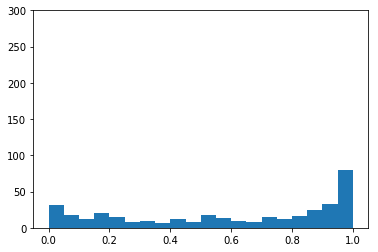

In [30]:
plt.hist(hpc.training_hit_probability,20)
plt.ylim(0,300)
plt.rcParams.update({'font.size': 18})

In [ ]:
predic_stats()

In [17]:
dic_results.keys()

dict_keys(['hcjoint', 's2df', 'hcdf', 's1df', 'hitproba'])

In [13]:
def stats_mask(y_true, y_pred, mask_selected=None):
    if mask_selected is None:
        mask_selected = np.ones(y_pred.shape).astype(bool)
    print('------------------------')
    print('Ratio:', y_true[mask_selected].sum()/y_true.sum()) 
    print('#    : ', y_true[mask_selected].sum()) 
    print('# true values: ',mask_selected.sum())
    print('ACC  : ', np.mean((y_true == y_pred)[mask_selected]))

In [14]:
print('Level 1')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float))

Level 1
------------------------
Ratio: 1.0
#    :  182
# true values:  370
ACC  :  0.708108108108


In [27]:
pos_mask = (dic_results['s2df'][:,1]>0)
acc_s2 = metrics.accuracy_score(y_val[tmp_mask], (dic_results['s1df'][:,0]>0).astype(float)[pos_mask])

NameError: name 'metrics' is not defined